<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/NLP/Kaggle_Fake_new/Fake_new_LSTM_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
raw_data_path = '/content/drive/My Drive/Data/NLP/Kaggle_Fake_news/news.csv'
destination_folder = '/content/drive/My Drive/Data/NLP/Kaggle_Fake_news'

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [5]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)
print(df_raw.shape)
df_raw.head()

(6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

df_raw.head()

,label,title,text,titletext
0,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...


In [7]:
# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

In [8]:
# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [9]:
df_train

,label,title,text,titletext
0,0,Obamacare's unlikely No. 1 city,"Killing Obama administration rules, dismantlin...",Obamacare's unlikely No. 1 city. Killing Obama...
1,0,New York restores order for 2016 front-runners,Hillary Clinton and Donald Trump scored resoun...,New York restores order for 2016 front-runners...
2,0,These political scientists may have just disco...,There's a lot of disgust in America with polit...,These political scientists may have just disco...
3,0,"Hillary supporters: We're excited, too, but al...",Trump and Sanders get all the attention for th...,"Hillary supporters: We're excited, too, but al..."
4,0,Hung jury in Jodi Arias sentencing phase remov...,The jury in the Jodi Arias case tasked with de...,Hung jury in Jodi Arias sentencing phase remov...
...,...,...,...,...
497,1,John Pilger: ‘The truth is… there was no one t...,Leave a Reply Click here to get more info on f...,John Pilger: ‘The truth is… there was no one t...
498,1,DEVELOPING: FBI Reopens Investigation into Cli...,The Clinton email scandal has taken an unexpec...,DEVELOPING: FBI Reopens Investigation into Cli...
499,1,Will Hillary Accept Defeat?,Print The headlines are in. Trump is the “anti...,Will Hillary Accept Defeat?. Print The headlin...
500,1,How to Solve the Illegal Immigration Problem,Republican presidential candidate Donald Trump...,How to Solve the Illegal Immigration Problem. ...


# Parameters

In [10]:
source_folder = '/content/drive/My Drive/Data/NLP/Kaggle_Fake_news'
destination_folder = '/content/drive/My Drive/Data/NLP/Kaggle_Fake_news'

# Libraries

In [11]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

1
Tesla K80
cuda:0


# Preliminaries

First, we use torchText to create a label field for the label in our dataset and a text field for the title, text, and titletext. We then build a TabularDataset by pointing it to the path containing the train.csv, valid.csv, and test.csv dataset files. We create the train, valid, and test iterators that load the data, and finally, build the vocabulary using the train iterator (counting only the tokens with a minimum frequency of 3).

In [16]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

# Models

We construct the LSTM class that inherits from the nn.Module. Inside the LSTM, we construct an Embedding layer, followed by a bi-LSTM layer, and ending with a fully connected linear layer. In the forward function, we pass the text IDs through the embedding layer to get the embeddings, pass it through the LSTM accommodating variable-length sequences, learn from both directions, pass it through the fully connected linear layer, and finally sigmoid to get the probability of the sequences belonging to FAKE (being 1).

In [19]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# Training

Before training, we build save and load functions for checkpoints and metrics. For checkpoints, the model parameters and optimizer are saved; for metrics, the train loss, valid loss, and global steps are saved so diagrams can be easily reconstructed later.

In [20]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [21]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

We train the LSTM with 10 epochs and save the checkpoint and metrics whenever a hyperparameter setting achieves the best (lowest) validation loss. Here is the output during training:

In [22]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [8/160], Train Loss: 0.7071, Valid Loss: 0.6748
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/model.pt
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/metrics.pt
Epoch [1/10], Step [16/160], Train Loss: 0.6981, Valid Loss: 0.6574
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/model.pt
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/metrics.pt
Epoch [2/10], Step [24/160], Train Loss: 0.5790, Valid Loss: 0.6444
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/model.pt
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/metrics.pt
Epoch [2/10], Step [32/160], Train Loss: 0.6038, Valid Loss: 0.6302
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/model.pt
Model saved to ==> /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/metrics.pt
Epoch [3/10], Step [40/160], Train Loss: 0.4856, Valid Loss: 0.6155
Model saved to ==> /content/d

Model loaded from <== /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/metrics.pt


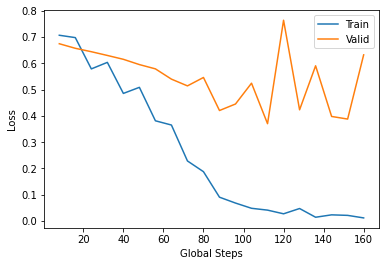

In [23]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Once we finished training, we can load the metrics previously saved and output a diagram showing the training loss and validation loss throughout time.

# Evaluation

In [24]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Model loaded from <== /content/drive/My Drive/Data/NLP/Kaggle_Fake_news/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8141    0.6811    0.7417      2816
           0     0.7290    0.8465    0.7834      2854

    accuracy                         0.7644      5670
   macro avg     0.7716    0.7638    0.7625      5670
weighted avg     0.7713    0.7644    0.7627      5670



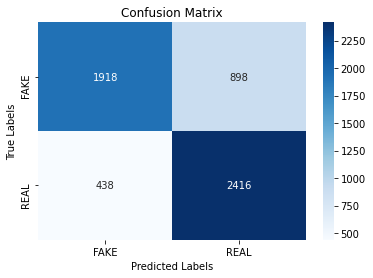

In [25]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Finally for evaluation, we pick the best model previously saved and evaluate it against our test dataset. We use a default threshold of 0.5 to decide when to classify a sample as FAKE. If the model output is greater than 0.5, we classify that news as FAKE; otherwise, REAL. We output the classification report indicating the precision, recall, and F1-score for each class, as well as the overall accuracy. We also output the confusion matrix.

We can see that with a one-layer bi-LSTM, we can achieve an accuracy of 77.53% on the fake news detection task.

Conclusion
This tutorial gives a step-by-step explanation of implementing your own LSTM model for text classification using Pytorch. We find out that bi-LSTM achieves an acceptable accuracy for fake news detection but still has room to improve. If you want a more competitive performance, check out my previous article on BERT Text Classification!